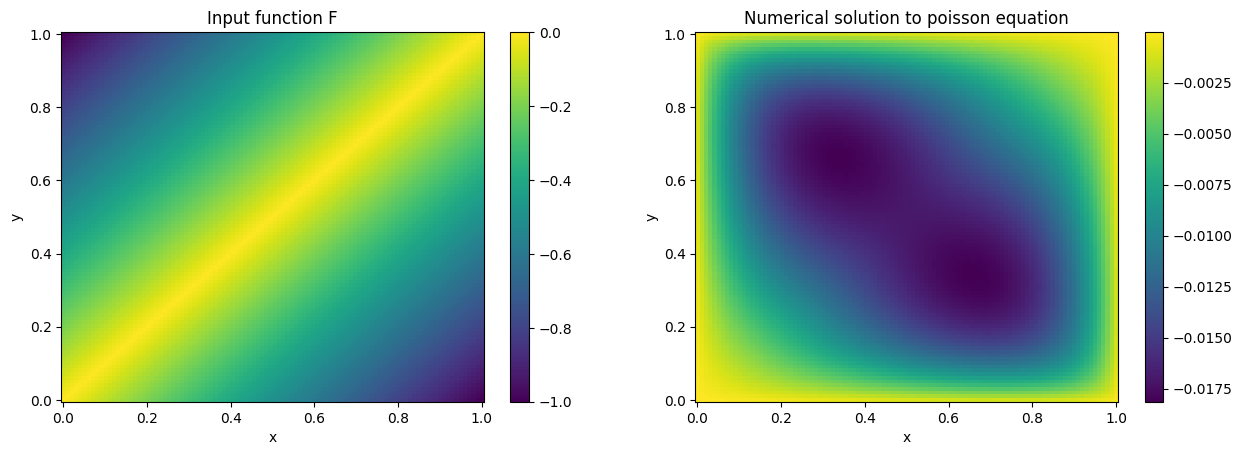

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import torch

N = 100
h = 1.0 / (N - 1)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)

# Define f
F = np.abs(X- 0.5) + np.abs(Y-0.5)
F = -np.abs(X-Y)

#redefine for numerical solver
F = -F
# Initialize the sparse matrix A
main_diagonal = np.ones(N**2) * -4 / h**2
offset_diagonals = np.ones(N**2 - 1) / h**2
offset_diagonals[N-1::N] = 0  # Fix the boundary effects where wrap-around occurs
far_diagonals = np.ones(N**2 - N) / h**2

# Create the sparse matrix A using diags
A = sp.diags(
    [main_diagonal, offset_diagonals, offset_diagonals, far_diagonals, far_diagonals],
    [0, -1, 1, -N, N], shape=(N**2, N**2), format='csr')

# Apply boundary conditions (zero boundary conditions applied by default)
F = F.ravel()



# Solve the linear system
u = scipy.sparse.linalg.spsolve(A, F)
U = u.reshape((N, N))

F = F.reshape(X.shape)

#return F to before
F = -F
# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(15)

fig1 = axs[0].pcolormesh(X,Y,F)
fig.colorbar(fig1)
axs[0].set_title("Input function F")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical solution to poisson equation")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()



#save input function

F = torch.tensor(F)[None,None,:]
torch.save(F,"../finput.pt")


In [56]:

import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO

from neuralop.training import Trainer 

from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from neuralop.training import CheckpointCallback
from neuralop.datasets.tensor_dataset import TensorDataset
from neuralop.datasets.output_encoder import UnitGaussianNormalizer
from neuralop.datasets.transforms import PositionalEmbedding2D
from neuralop.datasets.data_transforms import DefaultDataProcessor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [72]:
model = FNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 523257 parameters.


In [73]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

sys.stdout.flush()

In [74]:
#now for the data preparation process, following the darcy code

x_train = torch.load('../synthetic_data_dirichlet_10000_x.pt').clone().type(torch.FloatTensor)
x_train = x_train.to(device)
y_train = torch.load('../synthetic_data_dirichlet_10000_y.pt').clone().type(torch.FloatTensor)
y_train = torch.unsqueeze(y_train,1).to(device)
grid_boundaries=[[0, 1], [0, 1]]


input_encoder = None
reduce_dims = list(range(y_train.ndim))
output_encoder = UnitGaussianNormalizer(dim=reduce_dims)
output_encoder.fit(y_train)


train_db = TensorDataset(
        x_train,
        y_train,
    )


train_loader = torch.utils.data.DataLoader(
        train_db,
        batch_size=32,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        persistent_workers=False,
    )


pos_encoding = PositionalEmbedding2D(grid_boundaries=grid_boundaries)

data_processor = DefaultDataProcessor(
        in_normalizer=input_encoder,
        out_normalizer=output_encoder,
        positional_encoding=pos_encoding
    )
data_processor = data_processor.to(device)

In [75]:
trainer = Trainer(model=model, n_epochs=50,
                  device=device,
                  callbacks=[
                    CheckpointCallback(save_dir='./checkpoints',
                                       save_interval=10,
                                            save_optimizer=True,
                                            save_scheduler=True)
                        ],
                  data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False


In [76]:

trainer.train(train_loader=train_loader,
              test_loaders={},
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=None, 
              training_loss=train_loss)

Successfully saved training state to checkpoints
Saved training state to checkpoints
Successfully saved training state to checkpoints
Saved training state to checkpoints
Successfully saved training state to checkpoints
Saved training state to checkpoints
Successfully saved training state to checkpoints
Saved training state to checkpoints
Successfully saved training state to checkpoints
Saved training state to checkpoints


torch.Size([1, 3, 100, 100])
[[-0.00534313 -0.0068212  -0.0079138  ... -0.00786239 -0.00571516
  -0.00566726]
 [-0.00570841 -0.0065098  -0.00711239 ... -0.01005827 -0.00672373
  -0.00584667]
 [-0.00547774 -0.00576675 -0.00605713 ... -0.01311113 -0.00837456
  -0.00578505]
 ...
 [-0.00589831 -0.00837442 -0.01404934 ... -0.00401958 -0.00449735
  -0.00499787]
 [-0.00624    -0.00752351 -0.01106966 ... -0.00454584 -0.00500818
  -0.00530763]
 [-0.00620163 -0.00725262 -0.00934722 ... -0.00537834 -0.00545034
  -0.00547016]]


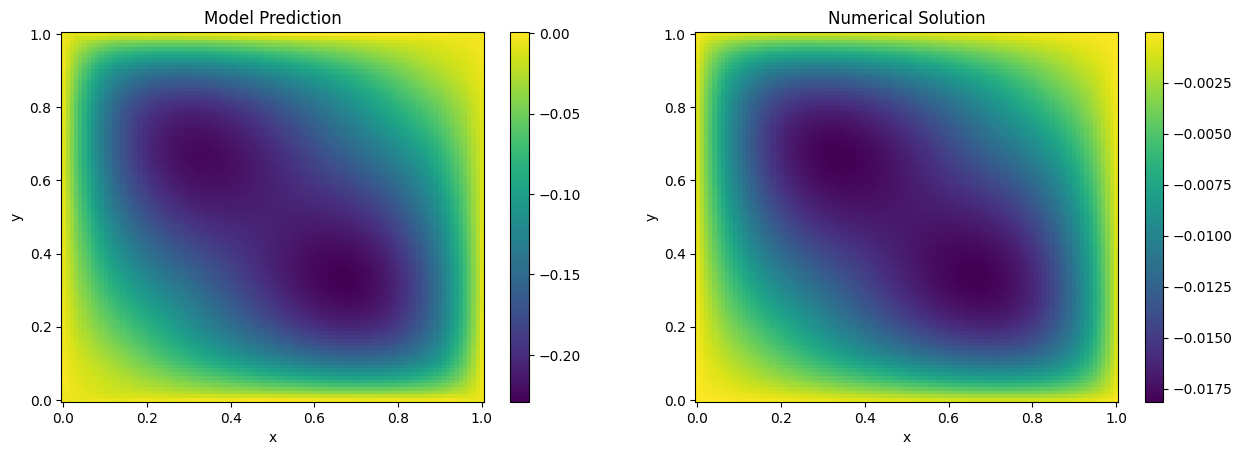

In [86]:
#prediction time
sample = torch.load("../finput.pt").clone().type(torch.FloatTensor)
sample = {"x": sample, "y": sample}
#preprocessing
sample = data_processor.preprocess(sample)
x = sample["x"]
print(x.shape)

out = model(x)[0,0,:,:].cpu().detach().numpy()
print(out)
# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(15)

fig1 = axs[0].pcolormesh(X,Y,out)
fig.colorbar(fig1)
axs[0].set_title("Model Prediction")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()
